- coisas para add 
    - data augmentation DONE 
    - matriz de confusao  DONE 
    - acuracia ao longo do tempo DONE 
    - nova ativacao(leaky relu) DONE 
    - tamanho dos modelos e arquiteura final  DONE 

    - CNN DONE 

# Imports

In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

import seaborn as sns

from torchinfo import summary

# Helper functions and MLP class

In [19]:
class CNN(nn.Module):
    def __init__(self, num_conv_layers, conv_channels, kernel_sizes, num_fc_layers, fc_hidden_sizes, 
                 num_classes=10, activation_function=nn.ReLU(), dropout_rate=0.0, use_batch_norm=True, pool_frequency=2):
        super(CNN, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm
        self.pool_frequency = pool_frequency
        
    
        self.conv_layers = nn.ModuleList()
        self.conv_batch_norms = nn.ModuleList()
        
        in_channels = 3
        for i in range(num_conv_layers):
            out_channels = conv_channels[i]
            kernel_size = kernel_sizes[i]
            padding = kernel_size // 2 
            
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            
            if use_batch_norm:
                self.conv_batch_norms.append(nn.BatchNorm2d(out_channels))
                
            in_channels = out_channels
        
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
        self.conv_output_size = self._calculate_conv_output_size()
        
    
        self.fc_layers = nn.ModuleList()
        self.fc_batch_norms = nn.ModuleList()
        
        fc_sizes = [self.conv_output_size] + fc_hidden_sizes + [num_classes]
        for i in range(len(fc_sizes) - 1):
            self.fc_layers.append(nn.Linear(fc_sizes[i], fc_sizes[i+1]))
            
            if use_batch_norm and i < len(fc_sizes) - 2:
                self.fc_batch_norms.append(nn.BatchNorm1d(fc_sizes[i+1]))
    
    def _calculate_conv_output_size(self):
        """Calcula dinamicamente o tamanho da saída das camadas convolucionais"""
        
        with torch.no_grad():
            x = torch.randn(1, 3, 32, 32)  
            
            
            for i, conv_layer in enumerate(self.conv_layers):
                x = conv_layer(x)
                
                if (i + 1) % self.pool_frequency == 0:
                    x = self.pool(x)
            
            
            return x.view(1, -1).size(1)
    
    def forward(self, x):

        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x)
            
            if self.use_batch_norm and i < len(self.conv_batch_norms):
                x = self.conv_batch_norms[i](x)
                
            x = self.activation_function(x)
            
            
            if (i + 1) % self.pool_frequency == 0:
                x = self.pool(x)
                
            x = self.dropout(x)
        
     
        x = x.view(x.size(0), -1)
    
        for i, fc_layer in enumerate(self.fc_layers[:-1]):
            x = fc_layer(x)
            
            if self.use_batch_norm and i < len(self.fc_batch_norms):
                x = self.fc_batch_norms[i](x)
                
            x = self.activation_function(x)
            x = self.dropout(x)
        
        x = self.fc_layers[-1](x)
        return x

In [20]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()  
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda() 
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val):
    plt.plot(arr_acc_train, label = "train accuracy")
    plt.plot(arr_acc_val, label = "val accuracy")
    plt.plot(arr_acc_test, label = "test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh', 'LeakyReLU'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'LeakyReLU' : nn.LeakyReLU()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    num_conv_layers = trial.suggest_int('num_conv_layers', 2, 6)
    
    pool_frequency = trial.suggest_int('pool_frequency', 2, 3)  
    
    conv_channels = []
    kernel_sizes = []
    
    for i in range(num_conv_layers):
        if i == 0:
            channels = trial.suggest_int(f'conv_channels_l{i}', 16, 64)
        else:
            prev_channels = conv_channels[i-1]
            channels = trial.suggest_int(f'conv_channels_l{i}', prev_channels, min(prev_channels * 2, 256))
            
        kernel_size = trial.suggest_categorical(f'kernel_size_l{i}', [3, 5])
        conv_channels.append(channels)
        kernel_sizes.append(kernel_size)
    

    num_fc_layers = trial.suggest_int('num_fc_layers', 1, 3)
    fc_hidden_sizes = []
    for i in range(num_fc_layers):
        fc_size = trial.suggest_int(f'fc_units_l{i}', 64, 512)
        fc_hidden_sizes.append(fc_size)

    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    try:
        model = CNN(
            num_conv_layers=num_conv_layers,
            conv_channels=conv_channels,
            kernel_sizes=kernel_sizes,
            num_fc_layers=num_fc_layers,
            fc_hidden_sizes=fc_hidden_sizes,
            num_classes=num_classes,
            activation_function=activation_function,
            dropout_rate=dropout_rate,
            use_batch_norm=use_batch_norm,
            pool_frequency=pool_frequency  
        ).cuda()
        
        with torch.no_grad():
            test_input = torch.randn(2, 3, 32, 32).cuda()
            test_output = model(test_input)
            
    except Exception as e:
        print(f"Erro na criação do modelo: {e}")
        return float('inf')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    try:
        for epoch in range(100):  
            model.train()
            for images, labels in train_loader:
                images = images.cuda()
                labels = labels.cuda()
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = evaluate_model(model, val_loader, loss_function)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                break
                
    except Exception as e:
        print(f"Erro no treinamento: {e}")
        return float('inf')
    
    return best_val_loss

# Setup

In [21]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

validation_dataset.dataset.transform = transform_test

In [22]:
# just to run fast
subset_sample      = 2000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [23]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [24]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [8]:
n_trials=50
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-14 22:23:32,895] A new study created in memory with name: no-name-ab7f438e-1c72-49ec-81cd-679edee8922a


## Best founded model

In [10]:
study.best_params

{'activation': 'Tanh',
 'learning_rate': 2.661614529026924e-05,
 'batch_size': 313,
 'dropout_rate': 0.39876406291127253,
 'weight_decay': 0.00019805086510847616,
 'use_batch_norm': True,
 'num_conv_layers': 5,
 'pool_frequency': 3,
 'conv_channels_l0': 23,
 'kernel_size_l0': 3,
 'conv_channels_l1': 35,
 'kernel_size_l1': 5,
 'conv_channels_l2': 58,
 'kernel_size_l2': 3,
 'conv_channels_l3': 70,
 'kernel_size_l3': 3,
 'conv_channels_l4': 92,
 'kernel_size_l4': 5,
 'num_fc_layers': 3,
 'fc_units_l0': 396,
 'fc_units_l1': 125,
 'fc_units_l2': 494}

In [11]:
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU' : nn.LeakyReLU()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [ ]:
best_params = study.best_params

cnn = CNN(
    num_conv_layers=best_params['num_conv_layers'],
    conv_channels=[best_params[f'conv_channels_l{i}'] for i in range(best_params['num_conv_layers'])],
    kernel_sizes=[best_params[f'kernel_size_l{i}'] for i in range(best_params['num_conv_layers'])],
    num_fc_layers=best_params['num_fc_layers'],
    fc_hidden_sizes=[best_params[f'fc_units_l{i}'] for i in range(best_params['num_fc_layers'])],
    num_classes=10,
    activation_function=activation_functions[best_params['activation']],
    dropout_rate=best_params['dropout_rate'],
    use_batch_norm=best_params['use_batch_norm']
).cuda()

optimizer = torch.optim.Adam(cnn.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

arr_acc_train = []
arr_acc_test  = []
arr_acc_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    cnn.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = cnn.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    cnn.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(cnn, val_loader, loss_function)
    test_loss  = evaluate_model(cnn, test_loader, loss_function)

    train_acc = evaluate_accuracy(cnn, train_loader)
    val_acc   = evaluate_accuracy(cnn, val_loader)
    test_acc  = evaluate_accuracy(cnn, test_loader)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    arr_acc_train.append(train_acc)
    arr_acc_val.append(val_acc)
    arr_acc_test.append(test_acc)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 1/10000 [00:01<3:19:21,  1.20s/it]

Epoch 1:
Train Loss: 2.4076
Val Loss: 2.2933
Test Loss: 2.2923


  0%|          | 2/10000 [00:02<3:18:46,  1.19s/it]

Epoch 2:
Train Loss: 2.3810
Val Loss: 2.2562
Test Loss: 2.2564


  0%|          | 3/10000 [00:03<3:17:38,  1.19s/it]

Epoch 3:
Train Loss: 2.3538
Val Loss: 2.2021
Test Loss: 2.2020


  0%|          | 4/10000 [00:04<3:16:11,  1.18s/it]

Epoch 4:
Train Loss: 2.3453
Val Loss: 2.1579
Test Loss: 2.1559


  0%|          | 5/10000 [00:05<3:15:09,  1.17s/it]

Epoch 5:
Train Loss: 2.3302
Val Loss: 2.1285
Test Loss: 2.1245


  0%|          | 6/10000 [00:07<3:14:29,  1.17s/it]

Epoch 6:
Train Loss: 2.3403
Val Loss: 2.1105
Test Loss: 2.1051


  0%|          | 7/10000 [00:08<3:14:19,  1.17s/it]

Epoch 7:
Train Loss: 2.3184
Val Loss: 2.0970
Test Loss: 2.0908


  0%|          | 8/10000 [00:09<3:14:13,  1.17s/it]

Epoch 8:
Train Loss: 2.2938
Val Loss: 2.0908
Test Loss: 2.0838


  0%|          | 9/10000 [00:10<3:15:07,  1.17s/it]

Epoch 9:
Train Loss: 2.2734
Val Loss: 2.0880
Test Loss: 2.0808


  0%|          | 10/10000 [00:11<3:14:57,  1.17s/it]

Epoch 10:
Train Loss: 2.2402
Val Loss: 2.0861
Test Loss: 2.0782


  0%|          | 11/10000 [00:12<3:14:59,  1.17s/it]

Epoch 11:
Train Loss: 2.2692
Val Loss: 2.0883
Test Loss: 2.0790


  0%|          | 12/10000 [00:14<3:15:03,  1.17s/it]

Epoch 12:
Train Loss: 2.2508
Val Loss: 2.0876
Test Loss: 2.0774


  0%|          | 13/10000 [00:15<3:14:00,  1.17s/it]

Epoch 13:
Train Loss: 2.2290
Val Loss: 2.0855
Test Loss: 2.0742


  0%|          | 14/10000 [00:16<3:13:12,  1.16s/it]

Epoch 14:
Train Loss: 2.2010
Val Loss: 2.0830
Test Loss: 2.0715


  0%|          | 15/10000 [00:17<3:12:32,  1.16s/it]

Epoch 15:
Train Loss: 2.1928
Val Loss: 2.0803
Test Loss: 2.0691


  0%|          | 16/10000 [00:18<3:12:35,  1.16s/it]

Epoch 16:
Train Loss: 2.1574
Val Loss: 2.0740
Test Loss: 2.0632


  0%|          | 17/10000 [00:19<3:12:11,  1.16s/it]

Epoch 17:
Train Loss: 2.1448
Val Loss: 2.0671
Test Loss: 2.0574


  0%|          | 18/10000 [00:20<3:12:23,  1.16s/it]

Epoch 18:
Train Loss: 2.1396
Val Loss: 2.0613
Test Loss: 2.0522


  0%|          | 19/10000 [00:22<3:12:20,  1.16s/it]

Epoch 19:
Train Loss: 2.1146
Val Loss: 2.0576
Test Loss: 2.0493


  0%|          | 20/10000 [00:23<3:11:56,  1.15s/it]

Epoch 20:
Train Loss: 2.1182
Val Loss: 2.0531
Test Loss: 2.0456


  0%|          | 21/10000 [00:24<3:11:47,  1.15s/it]

Epoch 21:
Train Loss: 2.0912
Val Loss: 2.0505
Test Loss: 2.0426


  0%|          | 22/10000 [00:25<3:11:52,  1.15s/it]

Epoch 22:
Train Loss: 2.1085
Val Loss: 2.0477
Test Loss: 2.0402


  0%|          | 23/10000 [00:26<3:12:32,  1.16s/it]

Epoch 23:
Train Loss: 2.0849
Val Loss: 2.0470
Test Loss: 2.0395


  0%|          | 24/10000 [00:27<3:12:30,  1.16s/it]

Epoch 24:
Train Loss: 2.0749
Val Loss: 2.0462
Test Loss: 2.0394


  0%|          | 25/10000 [00:29<3:12:01,  1.15s/it]

Epoch 25:
Train Loss: 2.0700
Val Loss: 2.0468
Test Loss: 2.0399


  0%|          | 26/10000 [00:30<3:11:48,  1.15s/it]

Epoch 26:
Train Loss: 2.0783
Val Loss: 2.0420
Test Loss: 2.0369


  0%|          | 27/10000 [00:31<3:11:43,  1.15s/it]

Epoch 27:
Train Loss: 2.0517
Val Loss: 2.0422
Test Loss: 2.0376


  0%|          | 28/10000 [00:32<3:11:24,  1.15s/it]

Epoch 28:
Train Loss: 2.0601
Val Loss: 2.0390
Test Loss: 2.0358


  0%|          | 29/10000 [00:33<3:11:32,  1.15s/it]

Epoch 29:
Train Loss: 2.0534
Val Loss: 2.0376
Test Loss: 2.0359


  0%|          | 30/10000 [00:34<3:12:17,  1.16s/it]

Epoch 30:
Train Loss: 2.0230
Val Loss: 2.0369
Test Loss: 2.0365


  0%|          | 31/10000 [00:36<3:11:46,  1.15s/it]

Epoch 31:
Train Loss: 2.0291
Val Loss: 2.0386
Test Loss: 2.0392


  0%|          | 32/10000 [00:37<3:11:46,  1.15s/it]

Epoch 32:
Train Loss: 2.0356
Val Loss: 2.0369
Test Loss: 2.0389


  0%|          | 33/10000 [00:38<3:11:56,  1.16s/it]

Epoch 33:
Train Loss: 2.0098
Val Loss: 2.0341
Test Loss: 2.0395


  0%|          | 34/10000 [00:39<3:11:42,  1.15s/it]

Epoch 34:
Train Loss: 1.9969
Val Loss: 2.0345
Test Loss: 2.0417


  0%|          | 35/10000 [00:40<3:11:17,  1.15s/it]

Epoch 35:
Train Loss: 2.0264
Val Loss: 2.0352
Test Loss: 2.0442


  0%|          | 36/10000 [00:41<3:11:14,  1.15s/it]

Epoch 36:
Train Loss: 2.0167
Val Loss: 2.0331
Test Loss: 2.0452


  0%|          | 37/10000 [00:42<3:11:02,  1.15s/it]

Epoch 37:
Train Loss: 1.9990
Val Loss: 2.0330
Test Loss: 2.0478


  0%|          | 38/10000 [00:44<3:11:14,  1.15s/it]

Epoch 38:
Train Loss: 1.9903
Val Loss: 2.0348
Test Loss: 2.0512


  0%|          | 39/10000 [00:45<3:11:13,  1.15s/it]

Epoch 39:
Train Loss: 1.9789
Val Loss: 2.0356
Test Loss: 2.0541


  0%|          | 40/10000 [00:46<3:11:18,  1.15s/it]

Epoch 40:
Train Loss: 2.0083
Val Loss: 2.0386
Test Loss: 2.0599


  0%|          | 41/10000 [00:47<3:11:03,  1.15s/it]

Epoch 41:
Train Loss: 1.9859
Val Loss: 2.0423
Test Loss: 2.0646


  0%|          | 41/10000 [00:48<3:17:01,  1.19s/it]

Epoch 42:
Train Loss: 1.9673
Val Loss: 2.0463
Test Loss: 2.0709
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

In [24]:
summary(cnn, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─ModuleList: 1-18                       --                        (recursive)
│    └─Conv2d: 2-1                       [1, 22, 32, 32]           1,672
├─Sigmoid: 1-2                           [1, 22, 32, 32]           --
├─Dropout: 1-3                           [1, 22, 32, 32]           --
├─ModuleList: 1-18                       --                        (recursive)
│    └─Conv2d: 2-2                       [1, 39, 32, 32]           21,489
├─Sigmoid: 1-5                           [1, 39, 32, 32]           --
├─MaxPool2d: 1-6                         [1, 39, 16, 16]           --
├─Dropout: 1-7                           [1, 39, 16, 16]           --
├─ModuleList: 1-18                       --                        (recursive)
│    └─Conv2d: 2-3                       [1, 74, 16, 16]           26,048
├─Sigmoid: 1-9                           [1, 74

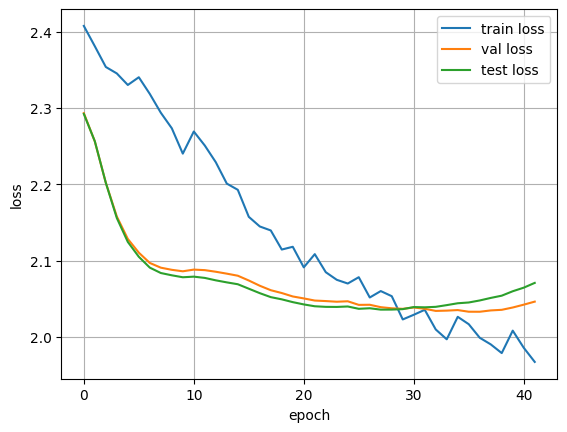

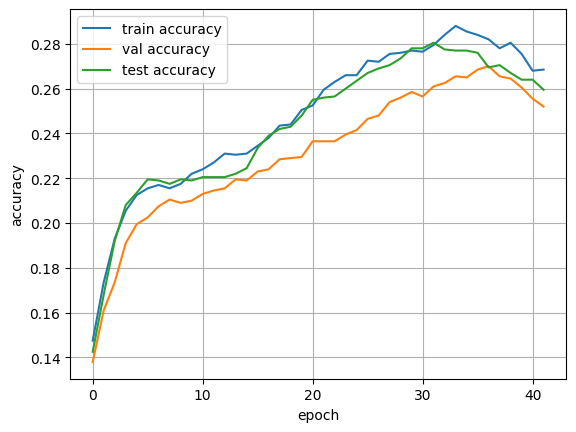

In [ ]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

plt.figure()  
show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4828431..1.2477095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24214405..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.499015

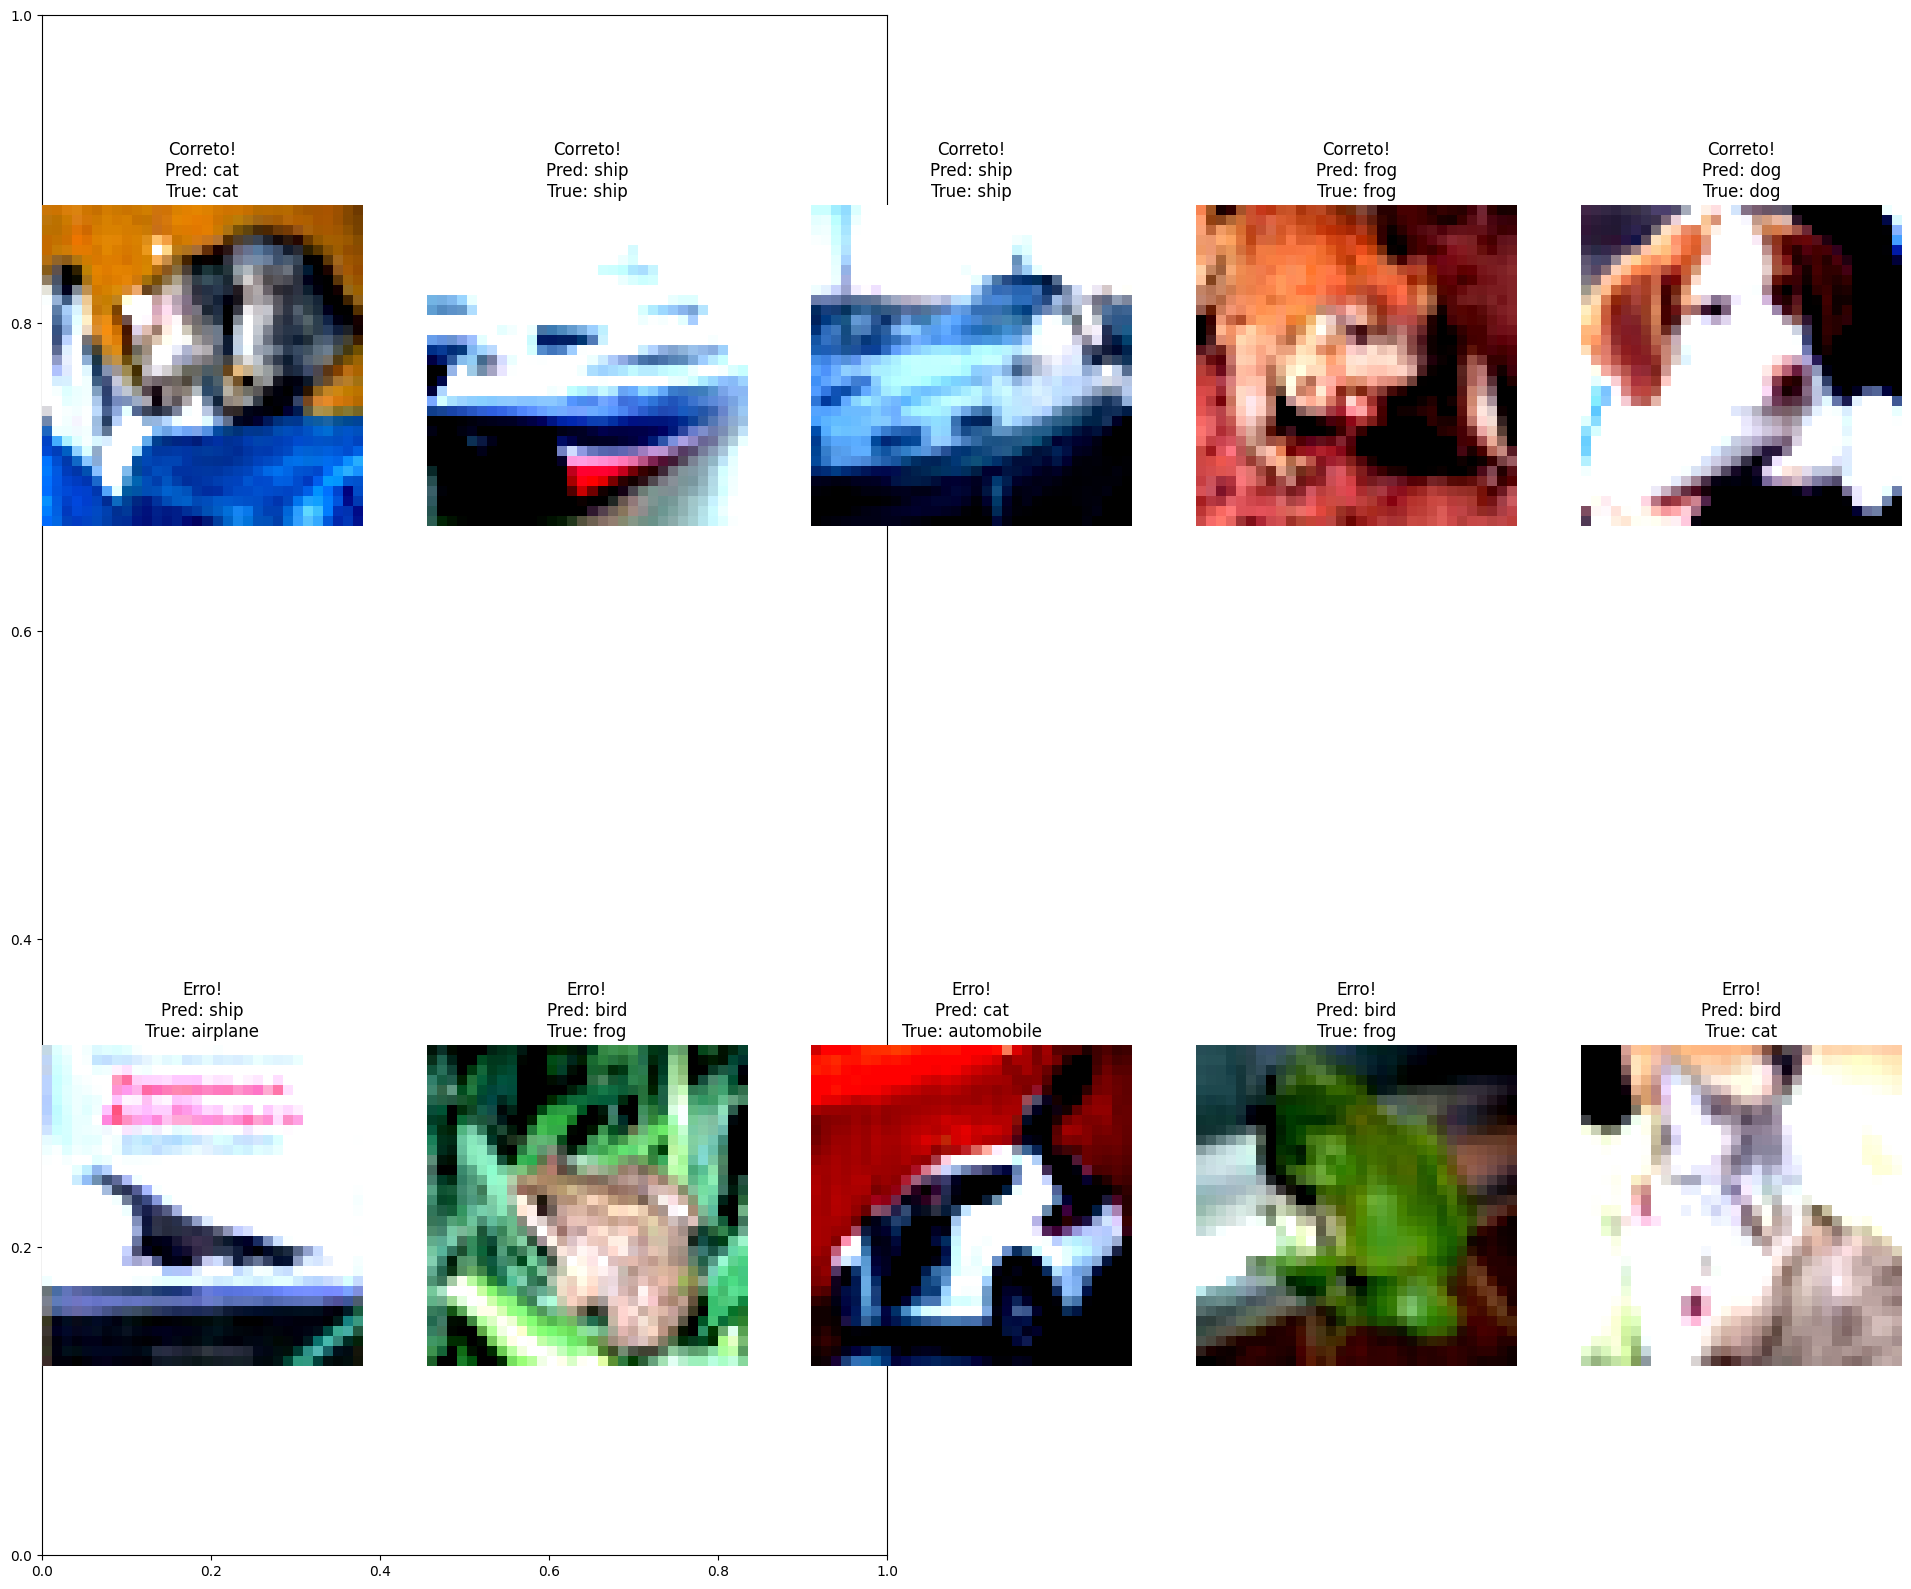

In [ ]:
show_predictions(cnn, test_loader, num_samples=5)

In [15]:
cnn.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.cuda()
  label = label.cuda()

  output = cnn(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.2595, 'balanced_accuracy': np.float64(0.25453218483957396), 'f1_score': 0.22751161171197742, 'precision': 0.3417631431076225, 'recall': 0.2595}




In [16]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 2000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 12.24%
  Número de amostras: 196
  Representatividade: 9.80%

automobile:
  Acurácia: 6.57%
  Número de amostras: 198
  Representatividade: 9.90%

bird:
  Acurácia: 45.64%
  Número de amostras: 195
  Representatividade: 9.75%

cat:
  Acurácia: 4.52%
  Número de amostras: 199
  Representatividade: 9.95%

deer:
  Acurácia: 34.85%
  Número de amostras: 198
  Representatividade: 9.90%

dog:
  Acurácia: 9.19%
  Número de amostras: 185
  Representatividade: 9.25%

frog:
  Acurácia: 23.15%
  Número de amostras: 216
  Representatividade: 10.80%

horse:
  Acurácia: 30.05%
  Número de amostras: 193
  Representatividade: 9.65%

ship:
  Acurácia: 76.50%
  Número de amostras: 217
  Representatividade: 10.85%

truck:
  Acurácia: 11.82%
  Número de amostras: 203
  Representatividade: 10.15%


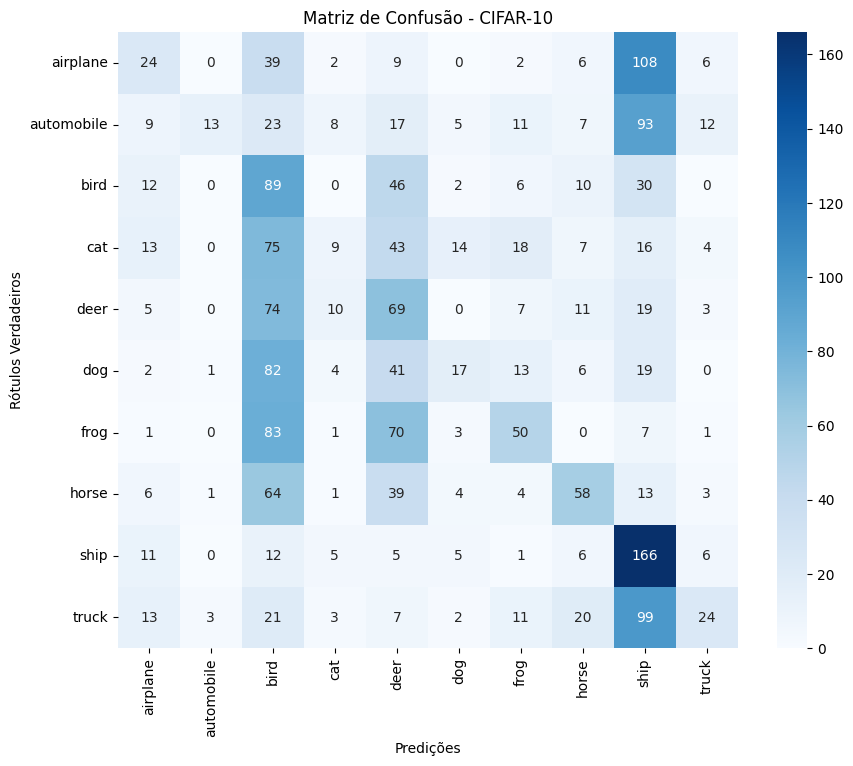

TRUE -> PRED
1. airplane → ship: 108 vezes
2. truck → ship: 99 vezes
3. automobile → ship: 93 vezes
4. frog → bird: 83 vezes
5. dog → bird: 82 vezes


In [ ]:
cm = metrics.confusion_matrix(labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - CIFAR-10')
plt.xlabel('Predições')
plt.ylabel('Rótulos Verdadeiros')
plt.show()

cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

flat_indices = np.argsort(cm_errors.ravel())[::-1][:5]
confusion_indices = np.unravel_index(flat_indices, cm_errors.shape)

print(f"TRUE -> PRED")
for i in range(5):
    true_class = confusion_indices[0][i]
    pred_class = confusion_indices[1][i]
    count = cm_errors[true_class, pred_class]
    if count > 0:
        print(f"{i+1}. {classes[true_class]} → {classes[pred_class]}: {count} vezes")